# `timex` example: Cradle-to-grave LCA of an electric vehicle


In [1]:
import bw2data as bd

bd.projects.set_current("bw25_premise")

## Prospective databases

Created using `premise` with updated electricity sectors


In [2]:
db_2020 = bd.Database("db_2020")
db_2030 = bd.Database("db_2030")
db_2040 = bd.Database("db_2040")

## Case study setup


Let's make sure we start from scratch:


In [3]:
del bd.databases["foreground"]
foreground = bd.Database("foreground")
foreground.write({})

Getting some input processes from the background database:


In [4]:
glider_production = bd.get_activity(("db_2020", "133b33cc867081af144475d62179286b"))
powertrain_production = bd.get_activity(
    ("db_2020", "f6d3f0b01e4a38c055e3c5c1356a4bba")
)  # eol included
battery_production = bd.get_activity(("db_2020", "ba87aff6361d99be2636e8c59e55a5b2"))
electricity_production = bd.get_activity(
    ("db_2020", "fec93a95a9a84d7fa0ede9c3082bb79f")
)
glider_eol = bd.get_activity(("db_2020", "f8114e0ff375b3c6d72ccfa49f79e44d"))
battery_eol = bd.get_activity(("db_2020", "82ebcdf42e8512cbe00151dda6210d29"))

Creating the EV activity:


In [5]:
fg = bd.Database("foreground")

In [6]:
fg.new_node("EV_lifecycle", name="Electric vehicle, lifecycle", unit="unit").save()
ev_lifecycle = fg.get("EV_lifecycle")

Here are some parameter assumptions:


In [7]:
ELECTRICITY_CONSUMPTION = 0.2  # kWh/km
MILEAGE = 150_000  # km
LIFETIME = 16  # years

# Overall mass: 1200 kg
MASS_GLIDER = 840  # kg
MASS_POWERTRAIN = 80  # kg
MASS_BATTERY = 280  # kg

Based on these parameters, we create the following exchanges:


In [8]:
ev_lifecycle.new_edge(input=ev_lifecycle, amount=1, type="production").save()

In [9]:
glider_production_exchange = ev_lifecycle.new_edge(
    input=glider_production, amount=MASS_GLIDER, type="technosphere"
)

In [10]:
powertrain_production_exchange = ev_lifecycle.new_edge(
    input=powertrain_production, amount=MASS_POWERTRAIN, type="technosphere"
)

In [11]:
battery_production_exchange = ev_lifecycle.new_edge(
    input=battery_production, amount=MASS_BATTERY, type="technosphere"
)

In [12]:
electricity_production_exchange = ev_lifecycle.new_edge(
    input=electricity_production,
    amount=ELECTRICITY_CONSUMPTION * MILEAGE,
    type="technosphere",
)

In [13]:
glider_eol_exchange = ev_lifecycle.new_edge(
    input=glider_eol,
    amount=MASS_GLIDER,  # amount not negative as its not modeled as a "true" waste process
    type="technosphere",
)

In [14]:
battery_eol_exchange = ev_lifecycle.new_edge(
    input=battery_eol, amount=-MASS_BATTERY, type="technosphere"
)

Adding temporal distributions to the new exchanges:


In [15]:
from bw_temporalis import TemporalDistribution, easy_timedelta_distribution
import numpy as np

In [16]:
td_production = easy_timedelta_distribution(
    start=-4,
    end=0,
    resolution="Y",  # M for months, Y for years, etc.
    steps=5,
    kind="triangular",
    param=-1,
)

td_use_phase = easy_timedelta_distribution(
    start=0,  # (inclusive)
    end=LIFETIME,  # (inclusive)
    resolution="Y",
    steps=(LIFETIME + 1),  # Includes both start and end
    kind="uniform",  # Could also be "triangular" or "uniform"
)

td_eol = TemporalDistribution(
    date=np.array([LIFETIME + 1], dtype="timedelta64[Y]"), amount=np.array([1])  # 2023
)

In [17]:
glider_production_exchange["temporal_distribution"] = td_production
glider_production_exchange.save()

powertrain_production_exchange["temporal_distribution"] = td_production
powertrain_production_exchange.save()

battery_production_exchange["temporal_distribution"] = td_production
battery_production_exchange.save()

electricity_production_exchange["temporal_distribution"] = td_use_phase
electricity_production_exchange.save()

glider_eol_exchange["temporal_distribution"] = td_eol
glider_eol_exchange.save()

battery_eol_exchange["temporal_distribution"] = td_eol
battery_eol_exchange.save()

## LCA using `timex`


In [18]:
method = ("EF v3.1", "climate change", "global warming potential (GWP100)")

In [19]:
from datetime import datetime

database_date_dict = {
    "db_2020": datetime.strptime("2020", "%Y"),
    "db_2030": datetime.strptime("2030", "%Y"),
    "db_2040": datetime.strptime("2040", "%Y"),
    "foreground": "dynamic",  # flag databases that should be temporally distributed with "dynamic"
}

In [20]:
from timex_lca import TimexLCA

tlca = TimexLCA({ev_lifecycle.key: 1}, method, database_date_dict, cutoff=1e-9)

/Users/timodiepers/Documents/Coding/timex/timex_lca/timex_lca.py:86: UserWarning: No edge filter function provided. Skipping all edges within background databases.
  warnings.warn(


Calculation count: 7


In [21]:
tlca.build_timeline()

/Users/timodiepers/Documents/Coding/timex/timex_lca/timeline_builder.py:301: Warning: Reference date 2041-01-01 00:00:00 is higher than all provided dates. Data will be taken from the closest lower year.
  warnings.warn(


,date_producer,producer_name,date_consumer,consumer_name,amount,interpolation_weights
0,2021-01-01,"market for glider, passenger car",2024-01-01,"Electric vehicle, lifecycle",140.0,"{'db_2020': 0.8998083766767041, 'db_2030': 0.1..."
1,2021-01-01,"battery production, Li-ion, LiMn2O4, rechargea...",2024-01-01,"Electric vehicle, lifecycle",46.666667,"{'db_2020': 0.8998083766767041, 'db_2030': 0.1..."
2,2021-01-01,"market for powertrain, for electric passenger car",2024-01-01,"Electric vehicle, lifecycle",13.333333,"{'db_2020': 0.8998083766767041, 'db_2030': 0.1..."
3,2022-01-01,"market for glider, passenger car",2024-01-01,"Electric vehicle, lifecycle",280.0,"{'db_2020': 0.7998905009581166, 'db_2030': 0.2..."
4,2022-01-01,"battery production, Li-ion, LiMn2O4, rechargea...",2024-01-01,"Electric vehicle, lifecycle",93.333333,"{'db_2020': 0.7998905009581166, 'db_2030': 0.2..."
5,2022-01-01,"market for powertrain, for electric passenger car",2024-01-01,"Electric vehicle, lifecycle",26.666667,"{'db_2020': 0.7998905009581166, 'db_2030': 0.2..."
6,2023-01-01,"market for glider, passenger car",2024-01-01,"Electric vehicle, lifecycle",420.0,"{'db_2020': 0.6999726252395291, 'db_2030': 0.3..."
7,2023-01-01,"battery production, Li-ion, LiMn2O4, rechargea...",2024-01-01,"Electric vehicle, lifecycle",140.0,"{'db_2020': 0.6999726252395291, 'db_2030': 0.3..."
8,2023-01-01,"market for powertrain, for electric passenger car",2024-01-01,"Electric vehicle, lifecycle",40.0,"{'db_2020': 0.6999726252395291, 'db_2030': 0.3..."
9,2024-01-01,"market group for electricity, low voltage",2024-01-01,"Electric vehicle, lifecycle",1764.705882,"{'db_2020': 0.6000547495209416, 'db_2030': 0.3..."


In [22]:
tlca.lci()

In [23]:
tlca.static_lcia()
tlca.score

15697.671861435201

## Dynamic Characterization

We provide two different metrics for dynamic LCIA of Climate Change: Radiative forcing and Global Warming Potential (GWP).

For the dynamic LCIA, users can select the length or the considered time horizon and whether it is a fixed time horizon. Fixed means that the time horizon for all emissions (no matter when they occur) starts counting at the time of the functional unit, resulting in shorter time horizons for emissions occuring later. If the time horizon is not fixed (this is what conventional impact assessment factors assume), it starts counting from the timing of the emission.


### Radiative forcing


In [24]:
tlca.dynamic_lcia(metric="radiative_forcing", fixed_time_horizon=True)

/Users/timodiepers/Documents/Coding/timex/timex_lca/dynamic_characterization.py:44: UserWarning: No custom dynamic characterization functions provided. Using default dynamic characterization functions based on IPCC AR6 meant to work with biosphere3 flows. The flows that are characterized are based on the selection of the initially chosen impact category: ('EF v3.1', 'climate change', 'global warming potential (GWP100)'). You can look up the mapping in the timex_lca.dynamic_characterizer.characterization_function_dict.
  warnings.warn(


,date,amount,flow,flow_name,activity,activity_name,amount_sum
0,2022-01-01 05:49:12,1.678511e-18,1617,"Methane, bromotrifluoro-, Halon 1301",41508,"(db_2020, ba87aff6361d99be2636e8c59e55a5b2)",1.678511e-18
152,2022-01-01 05:49:12,-1.657673e-28,1640,"Methane, dichlorodifluoro-, CFC-12",41508,"(db_2020, ba87aff6361d99be2636e8c59e55a5b2)",1.635622e-12
153,2022-01-01 05:49:12,2.824307e-17,3630,"Methane, from soil or biomass stock",27559,"(db_2020, 133b33cc867081af144475d62179286b)",1.635651e-12
154,2022-01-01 05:49:12,3.062504e-19,1613,"Methane, bromochlorodifluoro-, Halon 1211",41508,"(db_2020, ba87aff6361d99be2636e8c59e55a5b2)",1.635651e-12
155,2022-01-01 05:49:12,1.087367e-18,1612,"Methane, bromo-, Halon 1001",27559,"(db_2020, 133b33cc867081af144475d62179286b)",1.635652e-12
...,...,...,...,...,...,...,...
145359,2123-01-01 21:14:24,6.027501e-19,4261,"Ethane, 1,1,2-trichloro-1,2,2-trifluoro-, CFC-113",36946,"(db_2020, 82ebcdf42e8512cbe00151dda6210d29)",1.351929e-09
145358,2123-01-01 21:14:24,2.374436e-18,3632,"Carbon dioxide, from soil or biomass stock",36946,"(db_2020, 82ebcdf42e8512cbe00151dda6210d29)",1.351929e-09
145357,2123-01-01 21:14:24,3.335518e-25,717,Sulfur hexafluoride,46589,"(db_2020, f8114e0ff375b3c6d72ccfa49f79e44d)",1.351929e-09
145367,2123-01-01 21:14:24,1.365060e-23,1170,"Carbon dioxide, fossil",46589,"(db_2020, f8114e0ff375b3c6d72ccfa49f79e44d)",1.351930e-09


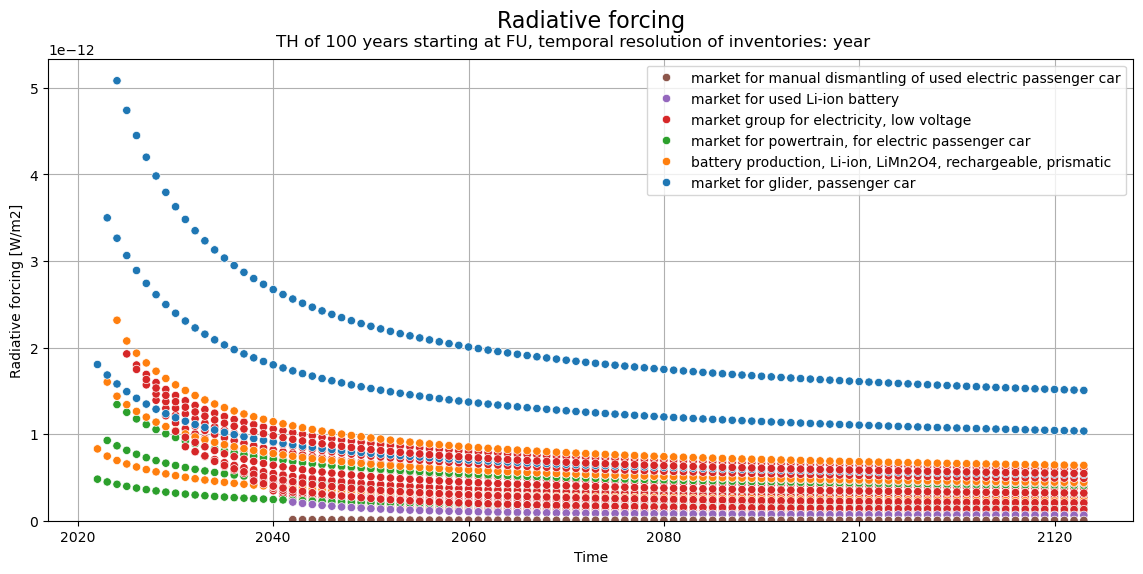

In [25]:
tlca.plot_dynamic_characterized_inventory(sum_emissions_within_activity=True)

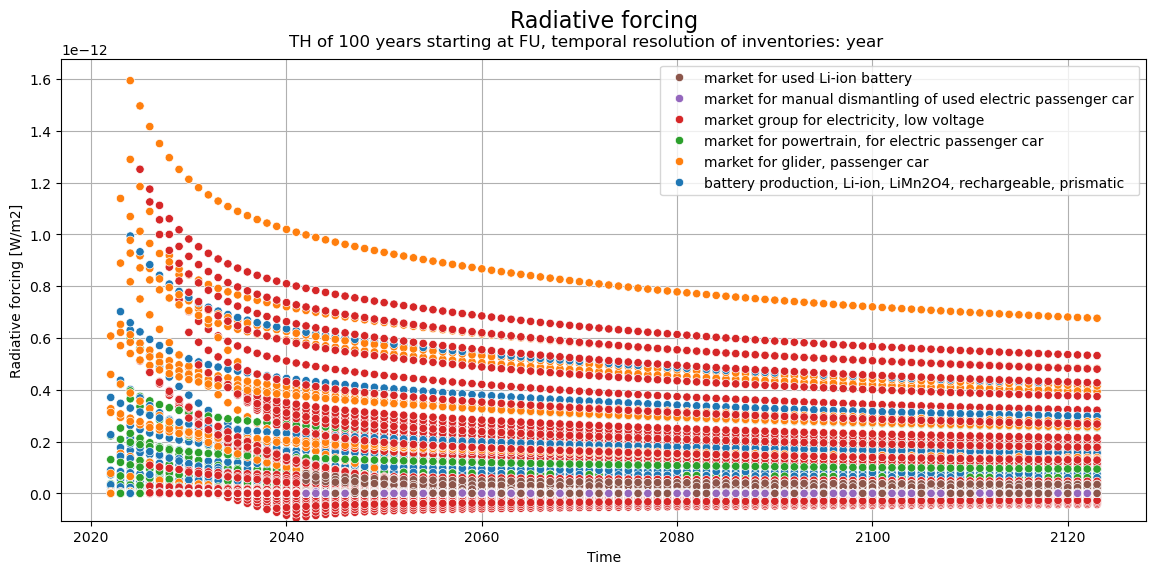

In [26]:
tlca.plot_dynamic_characterized_inventory()  # without summing up the emissions within the activity, one can see that there are also negative emissions in the system

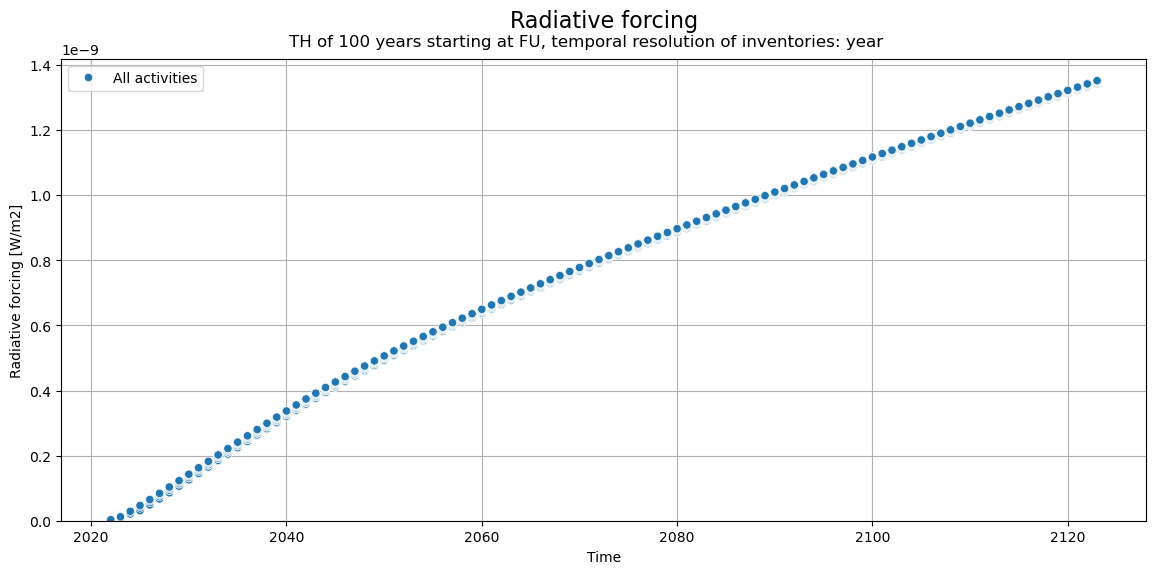

In [27]:
tlca.plot_dynamic_characterized_inventory(sum_activities=True, cumsum=True)

### GWP


In [28]:
tlca.dynamic_lcia(metric="GWP", fixed_time_horizon=True)

/Users/timodiepers/Documents/Coding/timex/timex_lca/dynamic_characterization.py:44: UserWarning: No custom dynamic characterization functions provided. Using default dynamic characterization functions based on IPCC AR6 meant to work with biosphere3 flows. The flows that are characterized are based on the selection of the initially chosen impact category: ('EF v3.1', 'climate change', 'global warming potential (GWP100)'). You can look up the mapping in the timex_lca.dynamic_characterizer.characterization_function_dict.
  warnings.warn(


,date,amount,flow,flow_name,activity,activity_name,amount_sum
0,2021-01-01,3.776823e+02,1168,"Carbon dioxide, fossil",27559,"(db_2020, 133b33cc867081af144475d62179286b)",377.682346
152,2021-01-01,1.123102e-03,1316,Ethane,46481,"(db_2020, f6d3f0b01e4a38c055e3c5c1356a4bba)",808.411738
153,2021-01-01,1.752907e-03,1327,"Ethane, 1,1,1,2-tetrafluoro-, HFC-134a",41508,"(db_2020, ba87aff6361d99be2636e8c59e55a5b2)",808.413491
154,2021-01-01,4.581713e-02,444,"Methane, trifluoro-, HFC-23",27559,"(db_2020, 133b33cc867081af144475d62179286b)",808.459308
155,2021-01-01,9.544407e-03,441,"Methane, tetrachloro-, R-10",46481,"(db_2020, f6d3f0b01e4a38c055e3c5c1356a4bba)",808.468853
...,...,...,...,...,...,...,...
2133,2041-01-01,3.118075e-03,1999,Sulfur hexafluoride,46589,"(db_2020, f8114e0ff375b3c6d72ccfa49f79e44d)",15176.916342
2134,2041-01-01,2.192335e-05,248,"Ethane, 1,1-difluoro-, HFC-152a",46589,"(db_2020, f8114e0ff375b3c6d72ccfa49f79e44d)",15176.916364
2135,2041-01-01,6.680989e-07,137,Chloroform,46589,"(db_2020, f8114e0ff375b3c6d72ccfa49f79e44d)",15176.916365
2157,2041-01-01,4.745582e+00,1171,"Carbon dioxide, fossil",36946,"(db_2020, 82ebcdf42e8512cbe00151dda6210d29)",15226.211103


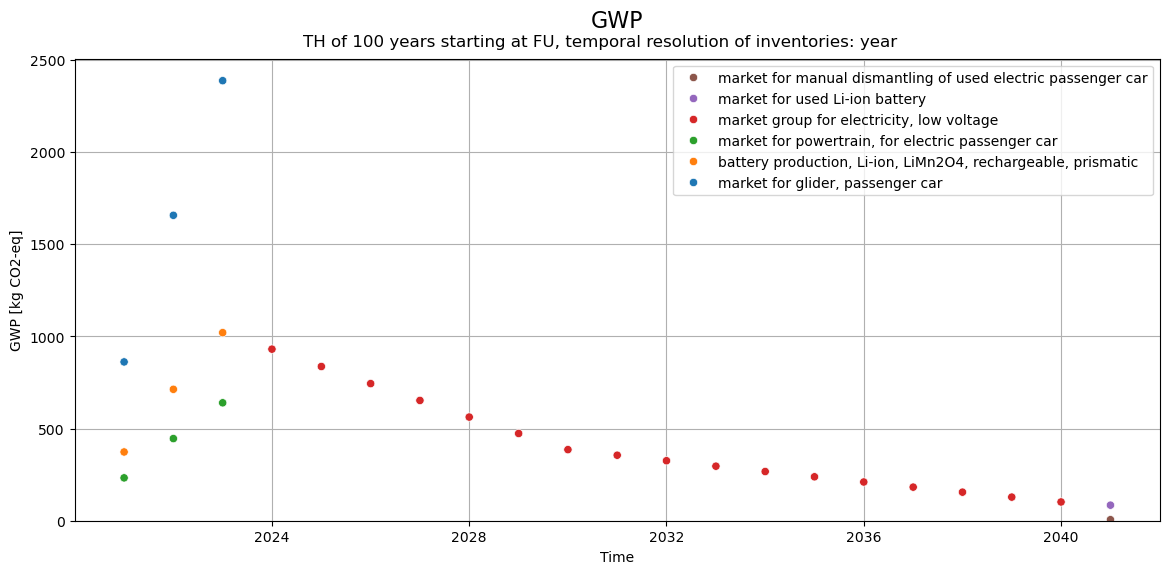

In [29]:
tlca.plot_dynamic_characterized_inventory(sum_emissions_within_activity=True)

In [30]:
import bw2calc as bc

static_scores = {}
for e in ev_lifecycle.exchanges():
    if e.input == ev_lifecycle.key:
        continue
    lca = bc.LCA({e.input: e.amount}, method)
    lca.lci()
    lca.lcia()
    static_scores[e.input["name"]] = lca.score

In [31]:
prospective_ev_lifecycle = ev_lifecycle.copy()

In [32]:
for exc in prospective_ev_lifecycle.exchanges():
    if exc.input == prospective_ev_lifecycle:
        continue
    exc.input = bd.get_node(
        **{
            "database": "db_2040",
            "name": exc.input["name"],
            "product": exc.input["reference product"],
            "location": exc.input["location"],
        }
    )
    exc.save()

In [33]:
prospective_scores = {}
for e in prospective_ev_lifecycle.exchanges():
    if e.input == prospective_ev_lifecycle.key:
        continue
    lca = bc.LCA({e.input: e.amount}, method)
    lca.lci()
    lca.lcia()
    prospective_scores[e.input["name"]] = lca.score

In [34]:
from timex_lca.utils import plot_characterized_inventory_as_waterfall

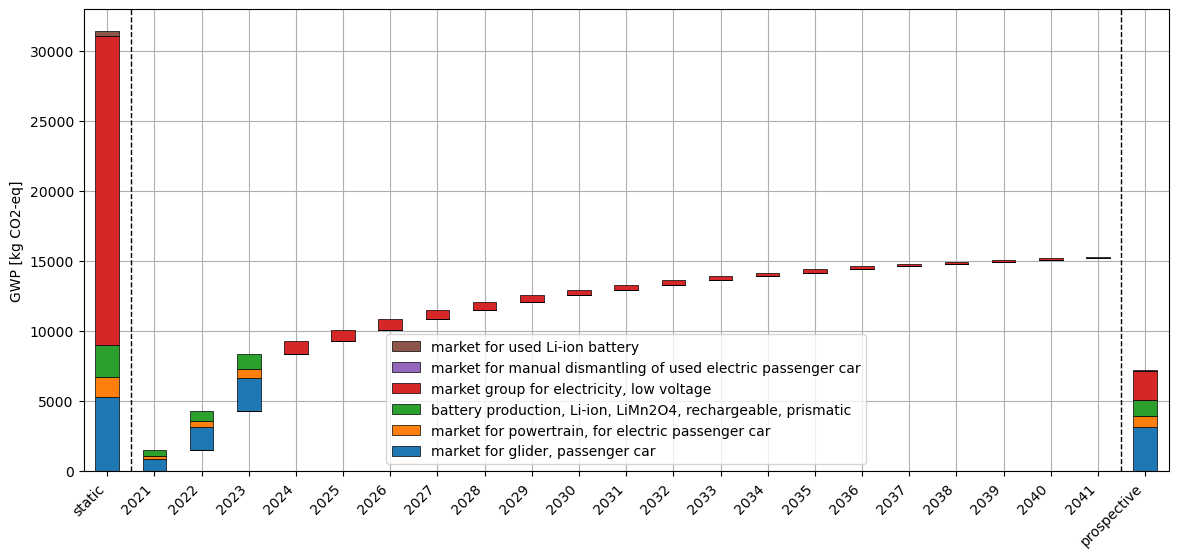

In [37]:
order_stacked_activities = (
    [  # to sort stacked bars in waterfall plot chronologically from production to EoL
        "market for glider, passenger car",
        "market for powertrain, for electric passenger car",
        "battery production, Li-ion, LiMn2O4, rechargeable, prismatic",
        "market group for electricity, low voltage",
        "market for manual dismantling of used electric passenger car",
        "market for used Li-ion battery",
    ]
)

plot_characterized_inventory_as_waterfall(
    tlca.characterized_inventory,
    metric=tlca.metric,
    static_scores=static_scores,
    prospective_scores=prospective_scores,
    order_stacked_activities=order_stacked_activities,
)